<a href="https://colab.research.google.com/github/KhawajaMuddassar/object_detection-and-image-classification/blob/main/instance_segmentation_mask_r_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instance Segmentation using Mask R-CNN**

**Mask R-CNN** (Region-based Convolutional Neural Networks for Object Detection and Instance Segmentation) is an advanced deep learning framework that extends the capabilities of Faster R-CNN to simultaneously perform both object detection and pixel-wise instance segmentation. By integrating a fully convolutional network (FCN) with region proposal networks (RPNs), Mask R-CNN enables the segmentation of individual object instances within an image, rather than just identifying bounding boxes around objects, making it a more robust tool for computer vision tasks such as object localization, classification, and segmentation.

A few modifications have been made to the Mask R-CNN architecture, as follow:
* The RoI Pooling layer replaced with the RoI Align layer
* A mask head has been included to predict a mask of objects in addition to the head
* A fully convolutional network (FCN) is leveraged for mask prediction

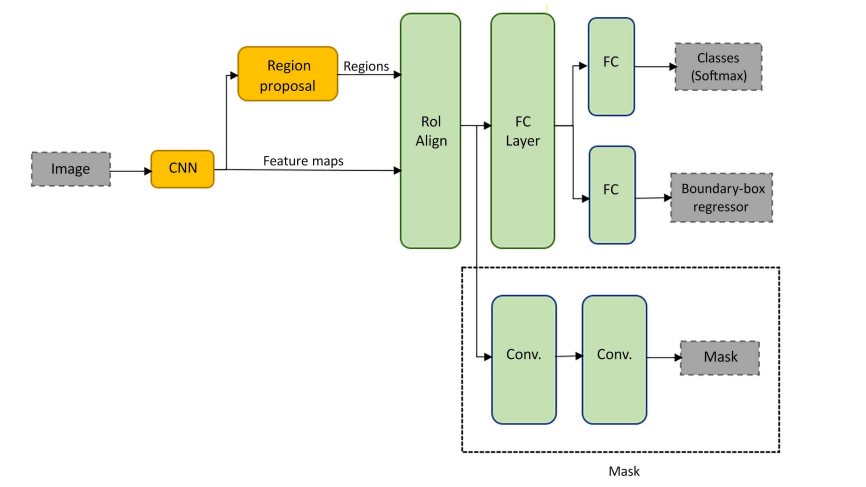


# **Implementing instance segmentation using Mask R-CNN**

To code Mask R-CNN for instance segmentation the strategy we'll adopt is as follows:
1. Fetch the dataset and then create datasets and dataloaders from it.
2. Create a ground truth in a format needed for PyTorch’s official implementation of Mask R-CNN.
3. Download the pre-trained Faster R-CNN model and attach a Mask R-CNN head to it.
4. Train the model with a PyTorch code snippet that has been standardized to train Mask R-CNN.
5. Infer on an image by performing non-max suppression first and then identifying the bounding
box and the mask corresponding to the people in the image.

In [ ]:
%pip install -qU torch_snippets
%pip install -q -U 'git+https://github.com/sizhky/cocoapi.git@patch-1#subdirectory=PythonAPI'
import os,shutil,re,time,urllib.request
from urllib.error import URLError
import urllib.request


class DataDownloader:
    def __init__(self):
        self.base_dir = '/content/MASK_R_CNN'  # Set the base directory to '/content/MASK_R_CNN'
        self.py_url_base = "https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/"  # URL base for .py files
        self.dataset_handler = None  # Placeholder for DatasetHandler

    def download_and_extract(self):
        # Make sure the base directory exists or clean it up before starting
        if os.path.exists(self.base_dir):
            # If base directory exists, clean it up and overwrite everything
            self._overwrite_directory(self.base_dir)
        else:
            os.makedirs(self.base_dir)
            print(f"Created base directory at: {self.base_dir}")
            # Change working directory to the base directory
        os.chdir(self.base_dir)
        print(f"Changed working directory to: {self.base_dir}")
            # Allow user to download datasets
        self._download_datasets()
        self._download_python_files()

    def _download_datasets(self):
        """Prompts the user to input URLs for datasets and download them."""
        while True:
            # Ask if the user wants to provide a URL for a dataset
            dataset_url = input("\nEnter the URL of the dataset to download or 'done' to finish: ").strip()
            if dataset_url.lower() == 'done':
                print("No more datasets to download. Exiting.\n")
                break
            elif self._is_valid_url(dataset_url):
                self._download_and_extract_dataset(dataset_url)
            else:
                print("Invalid URL. Please enter a valid dataset URL.")

    def _is_valid_url(self, url):
        """Check if the URL is valid for dataset download."""
        return url.startswith('http://') or url.startswith('https://')

    def _download_and_extract_dataset(self, url):
        """Downloads and extracts a dataset from the given URL."""
        # Get the dataset filename from the URL
        file_name = os.path.basename(url)
        print(f"Downloading {file_name} from {url}...")
        # Download the dataset file with progress reporting
        try:
            self._download_with_progress(url, os.path.join(self.base_dir, file_name))
            print(f"Downloaded {file_name} to {self.base_dir}")
            # Extract the downloaded file if it's an archive (tar, zip, etc.)
            self._extract_file(file_name)
        except URLError as e:
            print(f"Failed to download {file_name}. Error: {e}")
        except Exception as e:
            print(f"Failed to download {file_name}. Unexpected error: {e}")

    def _download_with_progress(self, url, save_path):
        """Download a file with a progress bar (status update)."""
        def report_progress(block_num, block_size, total_size):
            downloaded = block_num * block_size
            if total_size > 0:
                percent = min(100, (downloaded / total_size) * 100)
                status = f"\rDownloading... {percent:.2f}%"
                print(status, end='', flush=True)
            else:
                print(f"\rDownloading... {downloaded} bytes", end='', flush=True)
        try:
            urllib.request.urlretrieve(url, save_path, reporthook=report_progress)
            print()  # Print newline after the download progress bar
        except URLError as e:
            print(f"Download failed: {e}")

    def _extract_file(self, file_name):
        """Extract the downloaded dataset file if it's a supported format."""
        if file_name.endswith(('.tar.xz', '.tar', '.gz', '.zip')):
            print(f"Extracting {file_name}...")
            if file_name.endswith(('.tar.xz', '.tar')):
                os.system(f'tar -xf {os.path.join(self.base_dir, file_name)} -C {self.base_dir}')
            elif file_name.endswith('.zip'):
                os.system(f'unzip {os.path.join(self.base_dir, file_name)} -d {self.base_dir}')
            elif file_name.endswith('.gz'):
                os.system(f'gunzip {os.path.join(self.base_dir, file_name)}')
            print(f"Extraction complete: {file_name}")
            # Clean up the original compressed file after extraction
            os.remove(os.path.join(self.base_dir, file_name))
            print(f"Removed compressed file: {file_name}")
        else:
            print(f"{file_name} is not a recognized archive format. Skipping extraction.")

    def _overwrite_directory(self, path):
        """Helper function to remove files in subdirectories, delete directory and recreate it."""
        if os.path.isdir(path):
            # If the directory exists, ask the user if they want to overwrite
            user_input = input(f"The directory {path} already exists. Do you want to overwrite it? (yes/no): ").strip().lower()
            if user_input == 'no':
                print(f"Data already downloaded and exists at {path}. Skipping overwrite.")
                return  # Avoid overwriting and exit the function
            print(f"Removing folders and files inside: {path}")
            # Recursively delete all files and subdirectories
            for root, dirs, files in os.walk(path, topdown=False):
                for name in files:
                    try:
                        os.remove(os.path.join(root, name))
                    except Exception as e:
                        pass  # Ignore errors, just skip this file
                for name in dirs:
                    try:
                        os.rmdir(os.path.join(root, name))
                    except Exception as e:
                        pass  # Ignore errors, just skip this directory

            # Remove the base directory itself after its contents are cleaned
            try:
                os.rmdir(path)
            except Exception as e:
                pass  # Ignore errors, just skip this directory

            # Recreate the base directory
            os.makedirs(path)
            print(f"Recreated base directory: {path}")
            time.sleep(2)  # Give time for directory operations to complete
        elif os.path.isfile(path):
            os.remove(path)
            print(f"Removed file: {path}")
        else:
            print(f"Path {path} does not exist.")

    def _download_python_files(self):
        """Downloads a fixed set of Python files and stores them in the base directory."""
        files_to_download = ["engine.py","utils.py", "transforms.py", "coco_eval.py", "coco_utils.py" ]
        for file_name in files_to_download:
            file_url = self.py_url_base + file_name
            self._download_and_save(file_url, file_name)

    def _download_and_save(self, file_url, file_name):
        """Downloads the Python file and saves it in the base directory."""
        try:
            print(f"Downloading {file_name} from {file_url}...")
            urllib.request.urlretrieve(file_url, os.path.join(self.base_dir, file_name))
            print(f"Downloaded and saved {file_name} to {self.base_dir}")
        except Exception as e:
            print(f"Failed to download {file_name}. Error: {e}")


# Download Data Sets and need files
downloader = DataDownloader()
downloader.download_and_extract()

  Preparing metadata (setup.py) ... done
The directory /content/MASK_R_CNN already exists. Do you want to overwrite it? (yes/no): yes
Removing folders and files inside: /content/MASK_R_CNN
Recreated base directory: /content/MASK_R_CNN
Changed working directory to: /content/MASK_R_CNN

Enter the URL of the dataset to download or 'done' to finish: http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
Downloading... 100.00%
Downloaded annotations_instance.tar to /content/MASK_R_CNN
Extracting annotations_instance.tar...
Extraction complete: annotations_instance.tar
Removed compressed file: annotations_instance.tar

Enter the URL of the dataset to download or 'done' to finish: http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
Downloading... 100.00%
Downloaded images.tar to /content/MASK_R_CNN
Extracting images.tar...
Extraction complete: images.tar
Removed compressed file: images.tar

Enter the URL of the dataset to download or 'done' to finish

100%|██████████| 5000/5000 [00:32<00:00, 152.48it/s]


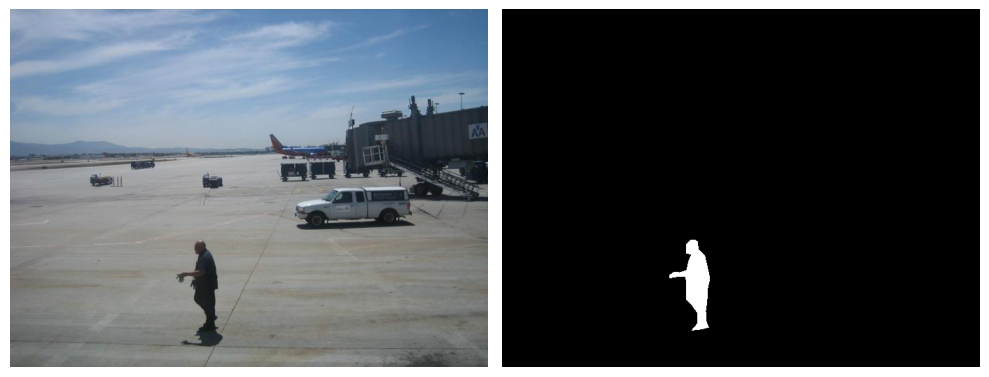

In [ ]:
!pip install -qU --upgrade torch_snippets
import torch, torchvision, sys, glob, numpy as np
from torch_snippets.paths import find,stems,Glob
from torch_snippets.loader import read, Tqdm,randint,subplots
from torch_snippets.torch_loader import DataLoader, Dataset
from torch_snippets.inspector import inspect
from torch_snippets import inspector
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from sklearn.model_selection import train_test_split
from PIL import Image
base_dir = '/content/MASK_R_CNN'
sys.path.append(base_dir)
from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

all_images = Glob(f'{base_dir}/images/traning')
all_anno = Glob(f'{base_dir}/annotations_instance/training')

# pick those annotatted files that contains atleast one person
annots = []
for ann in Tqdm(all_anno[:5000]):
    _ann = read(ann,1).transpose(2,0,1)
    # Red channel corespond to class of obj. while Green toinstance number
    # Person class is 4
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

# Split files into training and validation
file_splits = stems(annots)
train_items, val_items = train_test_split(file_splits, random_state=1)

#Transformation
def get_transform(train):
    image_transforms  = []
    image_transforms.append(T.PILToTensor())
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

# Dataset Class
class MasksDataset(Dataset):
    def __init__(self, items, transforms, Numfiles):
        self.items = items
        self.transforms = transforms
        self.Numfiles = Numfiles
    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8) :
          img = img/255.
        return img, target
    def __len__(self):
        return self.Numfiles
    def choose(self):
        return self[randint(len(self))]

# Inspect input-out
x = MasksDataset(train_items, get_transform(train=True), Numfiles=100)
img, targ = x[21]
#inspect(img, targ)
subplots([img, *targ['masks']],sz=10)


In [ ]:
from ast import Num
# Instance Segmentation model
def get_is_model(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

# Dataset and Dataloaders
dataset_train = MasksDataset(train_items, get_transform(train=True), Numfiles=len(train_items))
dataset_val = MasksDataset(val_items, get_transform(train=False), Numfiles=len(val_items))

#DataLoader
train_loader = DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)
val_loader = DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn)

#instantiate model
num_classes=2
model = get_is_model(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#lr schedular
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

num_epochs = 1

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, val_loader, device=device)



Epoch: [0]  [  0/467]  eta: 0:06:08  lr: 0.000016  loss: 3.0328 (3.0328)  loss_classifier: 0.7739 (0.7739)  loss_box_reg: 0.6518 (0.6518)  loss_mask: 1.5574 (1.5574)  loss_objectness: 0.0408 (0.0408)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 0.7880  data: 0.0698  max mem: 6477
Epoch: [0]  [ 10/467]  eta: 0:05:11  lr: 0.000123  loss: 2.2940 (2.3420)  loss_classifier: 0.6423 (0.6484)  loss_box_reg: 0.3649 (0.3884)  loss_mask: 1.2609 (1.2533)  loss_objectness: 0.0288 (0.0314)  loss_rpn_box_reg: 0.0149 (0.0205)  time: 0.6820  data: 0.0448  max mem: 6477
Epoch: [0]  [ 20/467]  eta: 0:05:19  lr: 0.000230  loss: 1.7595 (1.8091)  loss_classifier: 0.4757 (0.4803)  loss_box_reg: 0.3235 (0.3456)  loss_mask: 0.7270 (0.9062)  loss_objectness: 0.0265 (0.0487)  loss_rpn_box_reg: 0.0122 (0.0282)  time: 0.7120  data: 0.0402  max mem: 6477
Epoch: [0]  [ 30/467]  eta: 0:05:20  lr: 0.000337  loss: 1.0746 (1.5662)  loss_classifier: 0.2262 (0.3942)  loss_box_reg: 0.2897 (0.3361)  loss_mask: 0.4700 (0.7623) 

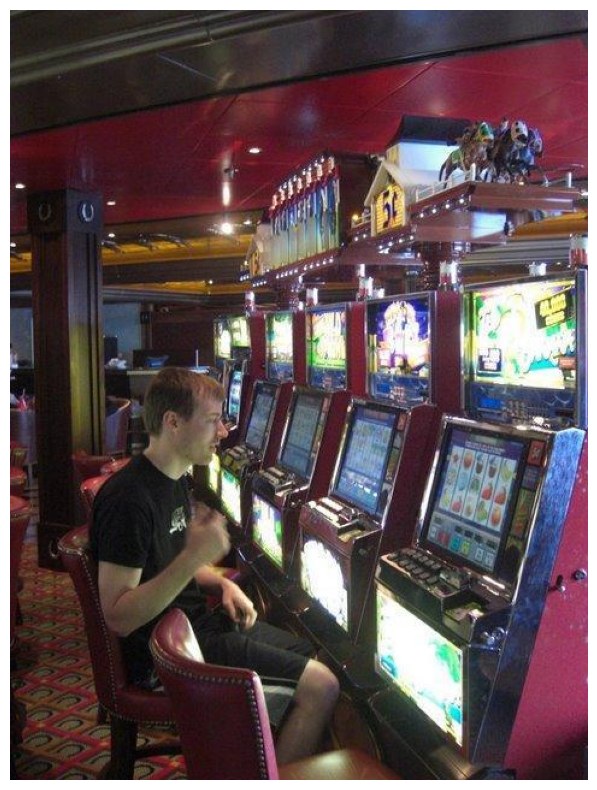

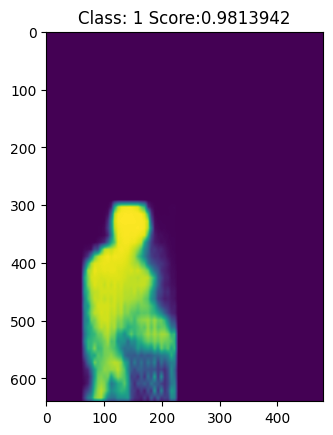

In [ ]:
import matplotlib.pyplot as plt
from torch_snippets import *

# Prediction
model.eval()
im = dataset_val[14][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()